In [1]:
import pandas as pd
from random import sample

from Broker import get_pnl
from uti import DataLoader, Logger
from Model.settings import DataCleaner

from Backtest import backtest_engine, plot_matrix, visual
from Backtest.settings import get_expectancy
from Model.rules import benchmark_filter, region_case_study
from library import Dataset
from Model.LR import LR
from Model.benchmark import REGION_MAPPING_DICT, MARKET_MAPPING_DICT

logger = Logger()
DL = DataLoader()
DATABASE_PATH = DL.database_path
DC = DataCleaner()
Engine = backtest_engine()

Engine current settings: 
daily_position 18 
region_position 6 
skewness: 0
Engine current settings: 
daily_position 18 
region_position 6 
skewness: 0
Engine current settings: 
daily_position 18 
region_position 6 
skewness: 0


In [2]:
import numpy as np
import pandas as pd
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations, combinations, product

## Preprocessing

In [150]:
train_data, test_data = DC.get_benchmark_test_data()
train_data = train_data[~train_data['d0_date'].isna()]
test_data = test_data[~test_data['d0_date'].isna()]

train_data['delta_r'] = (train_data['d0_close'] - train_data['d0_open']) / train_data['atr_used']
test_data['delta_r'] = (test_data['d0_close'] - test_data['d0_open']) / test_data['atr_used']

train_data['exch_region2'] = train_data['exch_region']
test_data['exch_region2'] = test_data['exch_region']

train_data['exch_location'] = train_data['exch_location'].replace(MARKET_MAPPING_DICT)
test_data['exch_location'] = test_data['exch_location'].replace(MARKET_MAPPING_DICT)

train_data['exch_region'] = train_data['exch_location'].replace(REGION_MAPPING_DICT)
test_data['exch_region'] = test_data['exch_location'].replace(REGION_MAPPING_DICT)

train_data.loc[train_data['exch_region2']=='Europe', 'exch_region'] = 'Europe'
test_data.loc[test_data['exch_region2']=='Europe', 'exch_region'] = 'Europe'

train_data['Sector'] = train_data['Sector'].fillna('').apply(lambda x: x.split(',')[0])
test_data['Sector'] = test_data['Sector'].fillna('').apply(lambda x: x.split(',')[0])

17:08:14 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/price_df.csv
Index(['Date', 'Time', 'Ticker', 'Tickers', 'company', 'Headline', 'Summary',
       'Region', 'Industry', 'Head analyst', 'Report Type', 'Report Types',
       'pubId', 'Headline sentiment', 'Summary sentiment', 'Sector', 'atr',
       'atrx', 'atr_used', 'gap', 'market_cap_usd', 'volume_d_10_sma',
       'prev1_date', 'prev1_open', 'prev1_high', 'prev1_low', 'prev1_close',
       'd0_date', 'd0_open', 'd0_high', 'd0_low', 'd0_close', 'd1_date',
       'd1_open', 'd1_high', 'd1_low', 'd1_close', 'd2_date', 'd2_open',
       'd2_high', 'd2_low', 'd2_close', 'ticker', 'exch_location',
       'exch_region', 'date_local', 'time_local', 'release_period',
       'ticker_updated', 'gap_in_atr'],
      dtype='object')
17:08:15 C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database//Backtest/Benchmark data created.
17:08:16 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/

In [151]:
REGION_MAPPING_DICT

{'Korea & Japan': 'Asia',
 'Hong Kong': 'Asia',
 'Taiwan & Singapore': 'Asia',
 'Southeast Asia': 'Asia',
 'Asia exotic': 'Asia',
 'South Africa': 'South Africa',
 'Americas': 'Americas',
 'China': 'Asia'}

In [152]:
train_data['exch_region'].value_counts()

Asia            6848
Europe          6025
Americas         699
South Africa     433
Australia         13
Turkey             5
Name: exch_region, dtype: int64

In [153]:
train_data['exch_location'].value_counts()

Korea & Japan         3334
United Kingdom        1692
Southeast Asia        1357
Taiwan & Singapore    1157
France                1010
Germany                892
Hong Kong              850
Americas               699
South Africa           433
Netherlands            426
Italy                  389
Sweden                 370
Spain                  260
Denmark                248
Switzerland            248
China                  150
Norway                 135
Belgium                122
Finland                 93
Ireland                 49
Austria                 47
Portugal                38
Australia               13
Turkey                   5
Czech Republic           3
Poland                   2
Greece                   1
Name: exch_location, dtype: int64

In [154]:
train_data[train_data['exch_region'].isna()]

,Date,Time,Ticker,Tickers,company,Headline,Summary,Region,Industry,Head analyst,...,gap_in_atr,market_cap_grp,No. of trades,side,stop_loss,d0_r,d1_r,d2_r,delta_r,exch_region2


In [155]:
def benchmark_rule(df_):
    df = df_[['Headline sentiment', 'Summary sentiment']].copy()
    
#     long_mask = ((df['Headline sentiment'] == 'positive') & (df['Summary sentiment'] != 'negative')) | ((df['Summary sentiment'] == 'positive') & (df['Headline sentiment'] != 'negative'))
    long_mask = ((df['Headline sentiment'] == 'positive') & (df['Summary sentiment'] == 'positive'))
    short_mask = (df['Headline sentiment'] == 'negative') | (df['Summary sentiment'] == 'negative')
    
    df['side'] = np.where(long_mask, 'long', 'neutral')
    df['side'] = np.where(short_mask, 'short', df['side'])
    
    return df['side']

In [156]:
train_data['side'] = benchmark_rule(train_data)
test_data['side'] = benchmark_rule(test_data)

train_data = get_pnl(train_data)
test_data = get_pnl(test_data)

17:08:33 Calculating pnl...
17:08:33 Row 0 BVTJ.J completed.
17:08:33 Row 1000 4704.T completed.
17:08:34 Row 2000 CPIN.JK completed.
17:08:35 Row 3000 0083.HK completed.
17:08:36 Row 4000 TW.L completed.
17:08:36 Row 5000 ABF.L completed.
17:08:37 Row 6000 GENM.KL completed.
17:08:38 Row 7000 STAN.L completed.
17:08:39 Row 8000 GFTU_u.L completed.
17:08:39 Row 9000 BAES.L completed.
17:08:40 Row 10000 YAZG.SI completed.
17:08:41 Row 11000 3626.T completed.
17:08:42 Row 12000 6841.T completed.
17:08:42 Row 13000 URW.AS completed.
17:08:43 Row 14000 MAERSKb.CO completed.
17:08:43 Calculating pnl...
17:08:43 Row 0 6701.T completed.
17:08:44 Row 1000 DAIR.SI completed.
17:08:45 Row 2000 SHEL.L completed.
17:08:45 Row 3000 CAGR.PA completed.
17:08:46 Row 4000 TEF.MC completed.
17:08:47 Row 5000 0522.HK completed.


In [157]:
def get_expectancy(_df, group_by=[]):
    # Given a dataset of trades, groupby based a given set of criteria, and output the expectancy of each group.
    df = _df[~_df['side'].isin(['neutral'])].copy()
    column = 'd0_r'
    inputs = ['No. of trades', column]
    inputs.extend(group_by)
    df.loc[:, 'No. of trades'] = 1  # maybe unnecessary
    if len(group_by) > 0:
        expectancy = df[inputs].groupby(group_by)[column].agg({
            ('Hit ratio', lambda x: (x > 0).sum() / len(x)),
            ('Loss ratio', lambda x: (x < 0).sum() / len(x)),
            ('Avg win size', lambda x: x[x > 0].mean()),
            ('Avg losing size', lambda x: x[x < 0].mean()),
            ('Count', 'count')}).fillna(0)
    else:
        expectancy = df[column].agg({
            'Hit ratio': lambda x: (x > 0).sum() / len(x) if len(x) > 0 else 0,
            'Loss ratio': lambda x: (x < 0).sum() / len(x) if len(x) > 0 else 0,
            'Avg win size': lambda x: x[x > 0].mean(),
            'Avg losing size': lambda x: x[x < 0].mean(),
            'No. of trades': lambda x: x.sum()})
    print(expectancy)
    try:
        expectancy['Expectancy'] = expectancy['Hit ratio'] * expectancy['Avg win size'] + \
                                   expectancy['Loss ratio'] * expectancy['Avg losing size']
    except:
        print(expectancy)
        print()
    return expectancy

In [171]:
def sub_ele_index(ele, row):
    result = []
    for sub_ele in ele:
        result.append(row[sub_ele])
    return tuple(result)

def get_daily_trade(_train_data, _test_data, score_weights = [], intercept=[0]):
#     exclusion_list = ['Australia', 'Turkey', 'Czech Republic', 'Poland', 'Greece', 'Americas']
    exclusion_list = []
    training_data = _train_data[~_train_data['exch_location'].isin(exclusion_list)].reset_index(drop=True).copy()
    testing_data = _test_data[~_test_data['exch_location'].isin(exclusion_list)].reset_index(drop=True).copy()
    
    all_data = pd.concat([training_data, testing_data], axis=0).copy()

    elements = [
#                 ['Ticker'], # Ticker + Head analyst
        # Head senti + Sum senti
        # Upgrade long, downgrade short, common sense way
        # AH, Earnings, sentiment only 
        # Rules regardless of senti, consistent bias.
        
                ['Head analyst'],
                ['exch_region'],
                ['Report Type'],
                ['Sector', 'market_cap_grp'],
                ]
    elements_name = []
    
    if len(score_weights) == 0:
        score_weights = [0.2] * len(elements)
    for ele in elements:
        expectancy = get_expectancy(training_data, group_by=ele)

        unique_values = []
        if len(ele) > 1:
            for sub_ele in ele:
                unique_values.append(all_data[sub_ele].unique())
            combinations = product(*unique_values)
            
        else:
            combinations = all_data[ele[0]].unique()
            
        case_unfound = set(combinations).difference(set(expectancy.index))
        case_unfound_df = pd.DataFrame(0, index=case_unfound, columns=expectancy.columns)
        expectancy = pd.concat([expectancy, case_unfound_df], axis=0)
        
        print(expectancy)
        
        
        if len(ele) > 1:
            ele_name = '_'.join(ele)+'_score'
            training_data[f'{ele_name}'] = [expectancy.loc[sub_ele_index(ele, row)]['Expectancy'] for _, row in training_data[ele].iterrows()]
            testing_data[f'{ele_name}'] = [expectancy.loc[sub_ele_index(ele, row)]['Expectancy'] for _, row in testing_data[ele].iterrows()]
        else:
            ele_name = ele[0] + '_score'
            training_data[f'{ele_name}'] = training_data[ele[0]].map(dict(expectancy['Expectancy'])).fillna(0)
            testing_data[f'{ele_name}'] = testing_data[ele[0]].map(dict(expectancy['Expectancy'])).fillna(0)
        print(ele_name)
        elements_name.append(ele_name)
        print(elements_name)
        
    training_data['score'] = np.sum(score_weights * training_data[elements_name],axis=1) + intercept[0]
    testing_data['score'] = np.sum(score_weights * testing_data[elements_name],axis=1) + intercept[0]
    
#     test_data.loc[test_data['score'] < 0, 'side'] = ''
#     test_data.loc[test_data['score'] < 0, 'score'] = 0
    
    return training_data, testing_data, elements_name


train_data, test_data, elements_name = get_daily_trade(train_data, test_data)

                 Avg losing size  Hit ratio  Count  Avg win size  Loss ratio
Head analyst                                                                
Aakanksha Anand        -0.729192   0.666667      9      0.520515    0.333333
Aaron Guy              -0.564184   0.526316     57      0.693393    0.473684
Adam G Cochrane        -1.000000   0.555556      9      0.477053    0.444444
Adam Spielman          -0.473042   0.535714     28      0.527774    0.464286
Air Ma, CFA            -0.033586   0.500000      2      2.414256    0.500000
...                          ...        ...    ...           ...         ...
Xiaopo Wei, CFA        -0.222888   0.000000      2      0.000000    1.000000
Yafei Tian, CFA        -0.465359   0.529412    153      0.645820    0.437908
Yuta Nishiyama         -0.553665   0.500000     48      0.637205    0.500000
Zoe Bian                0.000000   1.000000      1      1.168177    0.000000
宗像 陽                   -0.218085   0.000000      2      0.000000    1.000000

Sector_market_cap_grp_score
['Head analyst_score', 'exch_region_score', 'Report Type_score', 'Sector_market_cap_grp_score']


In [165]:
model = LR(train_data[elements_name], train_data[['d0_r']])
model.train()
model.evaluate()
# intercept = -0.03506858
# ols_weights = [0.86667071, 0.03735833, 0.16950042]
intercept, ols_weights = model.get_params()
# train_data['score'] = np.sum(ols_weights * train_data[elements_name],axis=1) + intercept[0]
train_data['score'] = np.mean(train_data[elements_name],axis=1)

# test_data['score'] = np.sum(ols_weights * test_data[elements_name],axis=1) + intercept[0]

Intercept: [-0.08061851]
Coefficients: [[-0.41307064  0.66508177  0.9619261   0.66501772]]
Score:  0.019293198361928998
R2 score:  0.019293198361928998
MSE score:  0.48271961741273206
RMSE score:  0.6947802655607973
                            OLS Regression Results                            
Dep. Variable:                   d0_r   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     65.39
Date:                Tue, 12 Apr 2022   Prob (F-statistic):           7.38e-55
Time:                        17:12:20   Log-Likelihood:                -14029.
No. Observations:               13300   AIC:                         2.807e+04
Df Residuals:                   13295   BIC:                         2.810e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                    

C:\Users\JayYang\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [144]:
strategy = 'scoring (PM) train'

pnl_df = train_data.copy()

lasso = Lasso(alpha=1e-3)
lasso.fit(pnl_df[elements_name], pnl_df['d0_r'])
print(lasso.coef_)
print(lasso.intercept_)

prediction = lasso.predict(pnl_df[elements_name])
r2 = r2_score(pnl_df['d0_r'], prediction)
mse = mean_squared_error(pnl_df['d0_r'], prediction)
rmse = np.sqrt(mse)

print('Score: ', lasso.score(pnl_df[elements_name], pnl_df['d0_r']))
print('R2 score: ', r2)
print('MSE score: ', mse)
print('RMSE score: ', rmse)


pnl_df['score'] =  np.sum(lasso.coef_ * pnl_df[elements_name],axis=1) + lasso.intercept_
# pnl_df = pnl_df[pnl_df['score']>0].reset_index(drop=True)
pnl_df = Engine.portfolio_management(pnl_df, rank_by='score')
DL.toBT(pnl_df, strategy)
vis2 = visual(strategy)
vis2.visual_job()

[ 0.57541289 -0.          0.05844148  0.75503428  0.34980766]
-0.07360358032577773
Score:  0.030359440650775893
R2 score:  0.030359440650775893
MSE score:  0.47727263546568505
RMSE score:  0.6908492132626953
17:05:15 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/scoring (PM) train.csv
17:05:15 C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/scoring (PM) train created.
side 
long     1645
short    1645
dtype: int64
 Sum of d0_r 451.96220491355575
 Sum of d1_r 585.0398476464845
 Sum of d2_r 656.3707124449722
Asia Sum of d0_r 227.24465685567336
Asia Sum of d1_r 286.9436652067785
Asia Sum of d2_r 363.43615353391056
Europe Sum of d0_r 220.92850815696985
Europe Sum of d1_r 293.82030191531373
Europe Sum of d2_r 291.57800903513146
South Africa Sum of d0_r 3.7890399009125066
South Africa Sum of d1_r 4.275880524392254
South Africa Sum of d2_r 1.356549875930114
Long trades hit ratio 0.5289
Short trades hit ratio 0.5617
Hit ratio           

              Hit ratio  Count  Loss ratio  Avg win size  Avg losing size
exch_region                                                              
Asia           0.544831   1896    0.414030      0.660576        -0.579784
Europe         0.543732   1372    0.446793      0.788484        -0.599153
South Africa   0.681818     22    0.318182      0.492819        -0.514748
                    Loss ratio  Avg win size  Count  Hit ratio  \
exch_region  side                                                
Asia         long     0.435654      0.687467    948   0.525316   
             short    0.392405      0.635544    948   0.564346   
Europe       long     0.462099      0.834138    686   0.529155   
             short    0.431487      0.745214    686   0.558309   
South Africa long     0.181818      0.408899     11   0.818182   
             short    0.454545      0.618697     11   0.545455   

                    Avg losing size  
exch_region  side                    
Asia         long        

## Ridge Regression

In [82]:
from sklearn.linear_model import Ridge, Lasso

[ 0.5807211  -0.31928579  0.41822255  0.87510177  0.43929446]
-0.09928457421641107


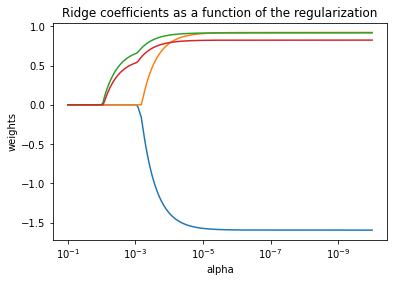

In [130]:
n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)

clf = linear_model.Lasso(fit_intercept=False)
coefs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(train_data[elements_name], train_data['d0_r'])
    coefs.append(clf.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
#将alpha的值取对数便于画图
ax.set_xscale('log')
#翻转x轴的大小方向，让alpha从大到小显示
ax.set_xlim(ax.get_xlim()[::-1]) 

plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [15]:
from Backtest import visual

In [159]:
strategy = 'benchmark'
DL.toBT(test_data, strategy)
# plot_matrix(strategy)
vis = visual(strategy)
vis.visual_job()

17:08:56 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/benchmark.csv
side   
long       2318
neutral    1793
short      1606
dtype: int64
 Sum of d0_r 349.9992745237494
 Sum of d1_r 511.9181291511592
 Sum of d2_r 515.2018084222727
Asia Sum of d0_r 239.38507896014556
Asia Sum of d1_r 332.18256294402954
Asia Sum of d2_r 333.8227731206528
Europe Sum of d0_r 97.71192770901013
Europe Sum of d1_r 164.02679850369975
Europe Sum of d2_r 158.86645802726974
New Zealand Sum of d0_r 0.0
New Zealand Sum of d1_r 0.0
New Zealand Sum of d2_r 0.0
South Africa Sum of d0_r 12.902267854593708
South Africa Sum of d1_r 15.708767703429949
South Africa Sum of d2_r 22.512577274350225
Long trades hit ratio 0.4676
Short trades hit ratio 0.5554
Hit ratio            0.503568
Loss ratio           0.465851
Avg win size         0.741622
Avg losing size     -0.610200
No. of trades      349.999275
Name: d0_r, dtype: float64


C:\Users\JayYang\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


       Loss ratio  Avg win size  Hit ratio  Count  Avg losing size
side                                                              
long     0.501726      0.766252   0.467645   2318        -0.630120
short    0.414072      0.711690   0.555417   1606        -0.575361
       Loss ratio  Avg win size  Hit ratio  Count  Avg losing size  Expectancy
side                                                                          
long     0.501726      0.766252   0.467645   2318        -0.630120    0.042186
short    0.414072      0.711690   0.555417   1606        -0.575361    0.157044


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
C:\Users\JayYang\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\JayYang\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


                    Hit ratio  Avg win size  Count  Loss ratio  \
exch_location                                                    
Austria              0.666667      0.647380     21    0.333333   
Belgium              0.545455      0.756292     55    0.454545   
China                0.454545      0.557640     66    0.530303   
Denmark              0.517241      0.538669     58    0.482759   
Finland              0.586207      0.348794     29    0.413793   
France               0.469697      0.870434    264    0.526515   
Germany              0.472340      0.704786    235    0.519149   
Hong Kong            0.572917      0.763067    384    0.395833   
Ireland              0.500000      0.509039     18    0.500000   
Italy                0.466667      0.908820     90    0.500000   
Korea & Japan        0.500000      0.700028   1022    0.485323   
Netherlands          0.500000      1.031164    110    0.500000   
Norway               0.523810      0.621748     42    0.476190   
Portugal  

C:\Users\JayYang\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\JayYang\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [160]:
strategy = 'benchmark (PM)'
pnl_df = test_data.copy()
# pnl_df = pnl_df[pnl_df['score']>0].reset_index(drop=True)
pnl_df['score'] = 0
pnl_df = Engine.portfolio_management(pnl_df, random_pick=True, rank_by='score')
DL.toBT(pnl_df, strategy)
# plot_matrix(strategy)
vis = visual(strategy)
vis.visual_job()

17:08:59 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/benchmark (PM).csv
side 
long     831
short    831
dtype: int64
 Sum of d0_r 145.2649466025197
 Sum of d1_r 199.54682586114356
 Sum of d2_r 210.96059797909584
Asia Sum of d0_r 104.12853531251659
Asia Sum of d1_r 154.0489134630057
Asia Sum of d2_r 163.54667651143916
Europe Sum of d0_r 41.26448029971879
Europe Sum of d1_r 45.497354771250755
Europe Sum of d2_r 47.852195629330154
South Africa Sum of d0_r -0.12806900971566182
South Africa Sum of d1_r 0.0005576268870866041
South Africa Sum of d2_r -0.4382741616735104
Long trades hit ratio 0.4513
Short trades hit ratio 0.5644
Hit ratio            0.507822
Loss ratio           0.460890
Avg win size         0.724075
Avg losing size     -0.608165
No. of trades      145.264947
Name: d0_r, dtype: float64
       Avg losing size  Avg win size  Count  Loss ratio  Hit ratio
side                                                              
long         -0.618958  

              Hit ratio  Count  Avg win size  Avg losing size  Loss ratio
exch_region                                                              
Asia           0.508677    922      0.718406        -0.569202    0.443601
Europe         0.506812    734      0.732683        -0.653372    0.482289
South Africa   0.500000      6      0.542922        -0.585612    0.500000
                    Avg win size  Avg losing size  Hit ratio  Count  \
exch_region  side                                                     
Asia         long       0.775448        -0.563099   0.438178    461   
             short      0.675250        -0.577045   0.579176    461   
Europe       long       0.726353        -0.688378   0.468665    367   
             short      0.738128        -0.611884   0.544959    367   
South Africa long       0.771244        -0.378417   0.333333      3   
             short      0.428761        -1.000000   0.666667      3   

                    Loss ratio  
exch_region  side           

In [172]:
strategy = 'scoring (PM)'

pnl_df = test_data.copy()
pnl_df['score'] =  np.mean(pnl_df[elements_name],axis=1)
# pnl_df['score'] = np.sum(lasso.coef_ * pnl_df[elements_name],axis=1) + lasso.intercept_
# pnl_df['score'] = np.sum(ols_weights * pnl_df[elements_name],axis=1) + intercept[0]
# pnl_df = pnl_df[pnl_df['score']>0].reset_index(drop=True)
pnl_df = Engine.portfolio_management(pnl_df, rank_by='score')
DL.toBT(pnl_df, strategy)
vis2 = visual(strategy)
vis2.visual_job()

17:37:52 Loading C:/Users/JayYang/OneDrive - Alpha Sherpa Capital/Citi\Database/Backtest/scoring (PM).csv
side 
long     817
short    817
dtype: int64
 Sum of d0_r 143.78552908500143
 Sum of d1_r 197.30289672310386
 Sum of d2_r 196.58893725934416
Asia Sum of d0_r 103.10916888691915
Asia Sum of d1_r 152.07035727914428
Asia Sum of d2_r 160.1264709982397
Europe Sum of d0_r 39.47144982828394
Europe Sum of d1_r 44.27169994567464
Europe Sum of d2_r 36.37790204995733
South Africa Sum of d0_r 1.2049103697983294
South Africa Sum of d1_r 0.9608394982849275
South Africa Sum of d2_r 0.08456421114712637
Long trades hit ratio 0.4455
Short trades hit ratio 0.5630
Hit ratio            0.504284
Loss ratio           0.463280
Avg win size         0.733286
Avg losing size     -0.608245
No. of trades      143.785529
Name: d0_r, dtype: float64
       Avg win size  Loss ratio  Hit ratio  Count  Avg losing size
side                                                              
long       0.768240    0.514076 

              Loss ratio  Avg losing size  Avg win size  Count  Hit ratio
exch_region                                                              
Asia            0.444444        -0.570982      0.721180    918   0.507625
Europe          0.488764        -0.652464      0.750785    712   0.498596
South Africa    0.250000        -0.423855      0.542922      4   0.750000
                    Hit ratio  Count  Avg losing size  Loss ratio  \
exch_region  side                                                   
Asia         long    0.435730    459        -0.559670    0.501089   
             short   0.579521    459        -0.585599    0.387800   
Europe       long    0.457865    356        -0.685590    0.530899   
             short   0.539326    356        -0.613087    0.446629   
South Africa long    0.500000      2        -0.423855    0.500000   
             short   1.000000      2         0.000000    0.000000   

                    Avg win size  
exch_region  side                 
Asia   

Asia            794
Europe          558
Americas         14
South Africa      2
Name: exch_region, dtype: int64

In [20]:
pnl_df['Date'].value_counts()

2022-02-24 00:00:00    14
2022-02-10 00:00:00    14
2021-11-09 00:00:00    12
2021-07-29 00:00:00    12
2021-11-02 00:00:00    12
                       ..
2021-09-21 00:00:00     2
2022-01-04 00:00:00     2
2022-03-02 00:00:00     2
2022-03-07 00:00:00     2
2021-06-16 00:00:00     2
Name: Date, Length: 206, dtype: int64

In [21]:
pnl_df = daily_trade.copy()
pnl_df['exch_region'] = pnl_df['exch_region'].replace({'Europe': 'Europe', 'Korea & Japan': 'Asia', 
                                                      'Southeast Asia': 'Asia', 'Hong Kong': 'Asia',
                                                      'Taiwan': 'Asia', 'Americas': 'Americas',
                                                      'South Africa': 'South Africa'})

NameError: name 'daily_trade' is not defined

In [ ]:
y = 'delta_r'
# y = 'd0_r'
# score_name = 'Ticker_score'
for score_name in elements_name:
    fig = plt.figure(figsize=(9, 6))
    plt.title(f'x:{score_name} y: delta_r')
    plt.scatter(train_data[score_name], train_data[y], s=0.4)

for score_name in elements_name:
    fig = plt.figure(figsize=(9, 6))
    plt.title(f'x:{score_name} y: delta_r')
    plt.scatter(test_data[score_name], test_data[y], s=0.4)

In [ ]:
# from collections import defaultdict

In [ ]:
daily_trade['Sector'].value_counts()

In [ ]:
daily_trade['exch_location'].value_counts()

In [ ]:
daily_trade['exch_region'].value_counts()